# Bird Song Recognition
**Define the Problem Statement**
We aim to develop a machine learning model that can recognize bird songs (or other animal sounds) from audio recordings.
Input: Audio recordings of bird songs
Output: Predicted bird species (or classification label)

**Tools & Libraries Required**
Python Libraries:
We'll use the following libraries for signal processing, machine learning, and deep learning:
Librosa – Audio processing
Scipy – Signal processing (Fourier transforms, filtering)
NumPy – Numerical computing
Matplotlib/Seaborn – Visualization
Pandas – Data handling
Scikit-learn – Machine learning algorithms
TensorFlow/PyTorch – Deep learning
Keras – Neural networks
Soundfile – Handling audio files



**Install necessary libraries:**

pip install librosa numpy scipy matplotlib seaborn pandas scikit-learn tensorflow keras soundfile

**Signal Processing for Feature Extraction**
To extract meaningful information, we apply Feature Extraction Techniques:
1.  Mel-Frequency Cepstral Coefficients (MFCCs) – Captures timbre and frequency features
2.  Spectrograms & Mel Spectrograms – Visual representation of frequency content
3.  Chroma Features – Highlights pitch and tone
4.  Zero Crossing Rate – Measures frequency of signal changes
5.  Spectral Contrast – Differentiates between harmonics and noise
6.  Librosa - used for audio processing, including loading audio, extracting features like MFCCs, chroma, and spectral contrast, and applying augmentations like time-stretching and pitch shifting.

In [ ]:
!pwd

/c/Users/Sumit/ownCloud/Documents/AppliedSignalProcessing


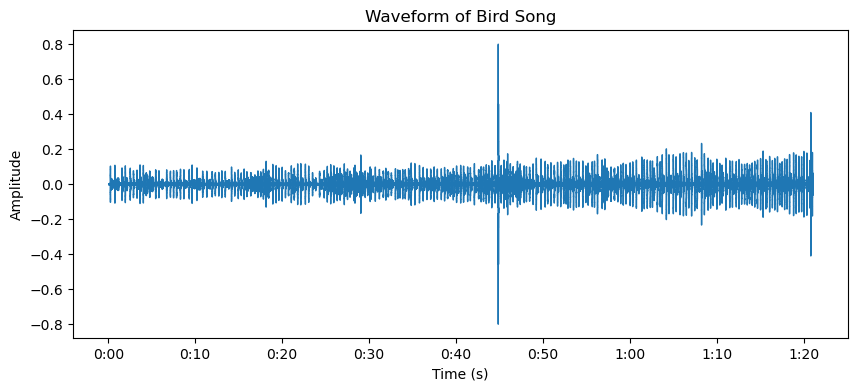

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import time
import os

os.getcwd
# Load an example bird song
# Ensure the file_path variable is correctly defined
file_path = r'c:/Users/Sumit/ownCloud/Documents/AppliedSignalProcessing/Sound/sample_bird_sound.wav'  # Correct the path format
y, sr = librosa.load(file_path, sr=None)  # y = waveform, sr = sample rate

# Plot the waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform of Bird Song")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


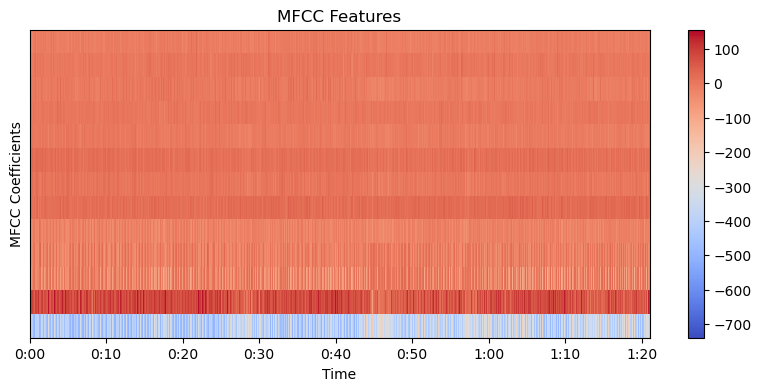

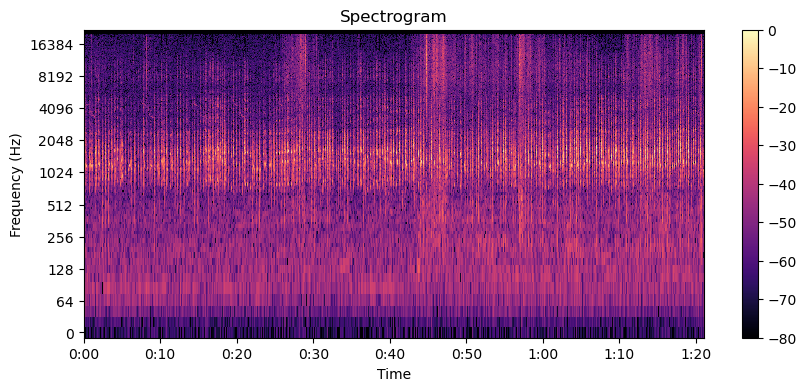

In [2]:
# Compute MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Compute Spectrogram
spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

# Plot MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()
plt.title("MFCC Features")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.show()

# Plot Spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.show()


**Prepare Data for Training**

we now have numerical features (MFCCs, Spectrograms), we need to:
1.  Normalize data (scale values between 0-1)
2.  Convert features into tabular format for ML models
3.  Label the dataset (bird species or classes)

In [3]:
import os
import numpy as np
import pandas as pd
import librosa
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from joblib import dump, load
from imblearn.over_sampling import RandomOverSampler
import soundfile as sf
import warnings


In [4]:

# === Step 1: Define Paths ===
DATA_DIR = Path(r"C:\Users\Sumit\ownCloud\Documents\AppliedSignalProcessing\Voices\AnimalSound")
MODEL_PATH = "animal_sound_model.pkl"  # Model will be saved here


In [5]:

# === Step 2: Extract Features Function ===
def extract_features(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=16000)  # Load audio at 16kHz
        if len(audio) == 0:
            return None
        
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)  # Extract 13 MFCC features
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)


        # Compute the mean and standard deviation of each feature
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        chroma_mean = np.mean(chroma, axis=1)
        chroma_std = np.std(chroma, axis=1)

        contrast_mean = np.mean(contrast, axis=1)
        contrast_std = np.std(contrast, axis=1)
        # Combine all features into a single array
        features = np.hstack((mfcc_mean, mfcc_std, chroma_mean, chroma_std, contrast_mean, contrast_std))
        return features # Return the feature array      
        #return np.mean(mfcc, axis=1)  # Use mean of MFCCs
    except Exception as e:
        print(f"Skipping {file_path}: {e}")
        return None


In [6]:

# === Step 3: Load Data ===
file_list = list(DATA_DIR.glob("*.wav"))  # Find all .wav files
labels = [file.stem.split("(")[0] for file in file_list]  # Extract labels from filenames

# Extract features using multiprocessing
features = [extract_features(file) for file in tqdm(file_list, desc="Extracting Features")]

# Remove invalid extractions
valid_data = [(f, l) for f, l in zip(features, labels) if f is not None]
if not valid_data:
    raise ValueError("No valid audio files found!")

features, labels = zip(*valid_data)
df = pd.DataFrame(features)
df["label"] = labels


Extracting Features:  16%|█▌        | 69/444 [00:08<00:17, 20.92it/s]C:\Users\Sumit\AppData\Local\Temp\ipykernel_37976\1581041185.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=16000)  # Load audio at 16kHz
c:\Users\Sumit\anaconda3\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Extracting Features:  95%|█████████▌| 424/444 [00:45<00:01, 12.52it/s]c:\Users\Sumit\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Extracting Features: 100%|██████████| 444/444 [00:46<00:00,  9.65it/s]


In [7]:
df['label']

0          Cat 
1          Cat 
2          Cat 
3          Cat 
4          Cat 
         ...   
439    warbler 
440    warbler 
441    warbler 
442    warbler 
443    warbler 
Name: label, Length: 444, dtype: object

In [8]:

# === Step 4: Encode Labels ===
encoder = LabelEncoder()
df["label"] = encoder.fit_transform(df["label"])


In [9]:

# === Step 5: Split Data ===
X = df.iloc[:, :-1]  # Features
y = df["label"]  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
334,-155.554214,48.144974,-139.442398,33.589409,-56.700935,-10.245946,-22.618345,18.881079,40.491501,6.466339,...,19.919732,73.061245,16.396136,3.370939,2.697876,4.718509,3.907304,3.035395,11.165299,4.894207
137,-403.704071,1.078271,-113.425591,-18.757584,-22.410305,1.533309,-7.747370,13.027903,-5.762233,0.622296,...,18.342100,20.865426,50.901393,5.680855,4.013667,5.215477,4.862848,3.952136,4.613964,7.512968
72,-37.183029,77.584785,-146.508194,65.687866,-37.179005,56.452103,-58.018211,18.347948,10.847016,-4.049734,...,20.352288,68.723921,14.529867,4.343883,2.576522,3.682822,3.199594,2.419340,10.018922,2.504061
365,-158.022705,-9.447709,-89.056038,-33.233109,-41.778763,-23.181826,-29.774883,-6.373854,-25.985720,-4.415626,...,17.652022,16.459915,57.290048,4.546187,3.560952,3.273360,4.733575,2.556858,1.881769,3.576514
73,-172.407990,106.844833,-64.835342,72.963455,-32.816055,51.116631,-13.226140,16.206099,2.379246,-13.450394,...,17.536707,70.902804,14.887418,3.633010,3.260578,3.127038,2.894035,3.566296,3.466054,1.210315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,-270.649780,20.415363,-28.606430,6.035397,-17.664307,-0.170773,-11.788706,0.351155,-5.363428,-6.231547,...,21.238983,21.021802,54.967338,8.440270,3.904125,5.217597,4.731191,4.239005,3.890368,6.036684
90,-395.750641,18.314426,-19.059345,8.521452,-9.762505,0.555726,-10.436552,-1.139030,0.102960,-0.795339,...,19.544053,19.607519,52.980824,10.287021,5.576618,5.103188,4.993835,4.830036,5.123367,5.705668
57,-126.855270,-70.152718,-89.709366,-1.682792,-7.730567,-14.780234,-6.993073,9.604435,-18.198708,16.511379,...,15.067857,15.124556,51.407922,6.321423,3.392638,4.780825,1.586493,1.385356,0.915471,3.364221
148,-256.039032,140.635391,35.560753,-3.959671,-11.914543,-4.876131,-17.197519,-5.250699,-11.744064,-1.876077,...,15.425830,17.344104,50.317555,4.825835,5.421801,4.740767,4.418594,1.962441,2.207504,6.540265


In [11]:

# === Step 6: Handle Imbalance (Optional) ===
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(X_train, y_train)

from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)



In [12]:
ros,smote

(RandomOverSampler(), SMOTE())

In [13]:

# === Step 7: Scale Features ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [14]:

# === Step 8: Train Model ===
clf = RandomForestClassifier(n_estimators=1200, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=1200, n_jobs=-1, random_state=42)

In [15]:

# === Step 9: Evaluate Model ===
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("\n=== Model Performance ===")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=1))



=== Model Performance ===
Accuracy: 0.6966
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.83      1.00      0.91         5
           2       1.00      0.78      0.88         9
           3       1.00      0.83      0.91         6
           4       0.50      0.50      0.50         4
           5       0.80      0.67      0.73         6
           6       0.29      0.67      0.40         3
           7       1.00      0.00      0.00         2
           8       1.00      0.40      0.57         5
           9       0.40      1.00      0.57         2
          10       0.60      0.75      0.67         4
          11       0.60      0.43      0.50         7
          12       0.57      1.00      0.73         4
          14       0.57      1.00      0.73         4
          15       0.83      1.00      0.91         5
          16       0.67      1.00      0.80         4
          18  

In [16]:

# === Step 10: Save Model & Encoder ===
dump(clf, MODEL_PATH)
dump(encoder, "label_encoder.pkl")
print(f"Model saved as {MODEL_PATH}")

print("Label encoder saved as label_encoder.pkl")
# === Step 11: Load Model & Encoder ===
loaded_model = load(MODEL_PATH)
loaded_encoder = load("label_encoder.pkl")
print(f"Model loaded from {MODEL_PATH}")
print("Label encoder loaded from label_encoder.pkl")

# === Step 12: Predict on New Audio ===
def predict_audio(file_path):
    features = extract_features(file_path)
    if features is None:
        return None
    
    features = scaler.transform([features])  # Scale the features
    prediction = loaded_model.predict(features)
    predicted_label = loaded_encoder.inverse_transform(prediction)[0]
    return predicted_label


Model saved as animal_sound_model.pkl
Label encoder saved as label_encoder.pkl
Model loaded from animal_sound_model.pkl
Label encoder loaded from label_encoder.pkl


In [17]:

# Example usage
test_file = r"C:\Users\Sumit\Downloads\Sample.wav"  # Replace with your test file path
predicted_label = predict_audio(test_file)  # Predict the label of the test audio
if predicted_label is not None:
    print(f"Predicted label for {test_file}: {predicted_label}")            
else:
    print(f"Could not extract features from {test_file}.")

# === Step 13: Save Audio with Predicted Label ===
def save_audio_with_label(input_file, output_dir, predicted_label):
    audio, sr = librosa.load(input_file, sr=16000)
    output_file = os.path.join(output_dir, f"{predicted_label}.wav")
    sf.write(output_file, audio, sr)
    print(f"Saved audio with predicted label '{predicted_label}' to {output_file}")

    


Predicted label for C:\Users\Sumit\Downloads\Sample.wav: Quail 


Data Augmentation

In [18]:
import librosa
import numpy as np
import librosa.display
import random

import librosa
import numpy as np
import random

def augment_audio(file_path):
    y, sr = librosa.load(file_path, sr=16000, mono=True)  # Ensure mono audio
    
    # Time Stretching (Avoid using a rate of 1, as it does nothing)
    # Randomly choose a rate between 0.8 and 1.2 (avoiding 1.0)
    # to stretch the audio
    rate = random.uniform(0.8, 1.2)
    y_stretched = librosa.effects.time_stretch(y, rate)

    # Pitch Shift (Avoid shifting by 0 semitones)
    steps = random.randint(-2, 2)
    if steps != 0:
        y_shifted = librosa.effects.pitch_shift(y_stretched, sr, n_steps=steps)
    else:
        y_shifted = y_stretched

    # Add Noise (Gaussian noise)
    noise = np.random.normal(0, 0.005, y_shifted.shape)
    y_noisy = y_shifted + noise
    
    return y_noisy, sr



# Example usage
input_file = r"C:\Users\Sumit\Downloads\Sample.wav"  # Replace with your test file path
output_dir = r"C:\Users\Sumit\Downloads"  # Replace with your output directory
predicted_label = predict_audio(input_file)  # Predict the label of the test audio
y_augmented, sr = augment_audio(input_file)  # Augment the audio
save_audio_with_label(input_file, output_dir, predicted_label)  # Save the augmented audio with predicted label
# Save the augmented audio
output_file = os.path.join(output_dir, f"{predicted_label}_augmented.wav")







TypeError: time_stretch() takes 1 positional argument but 2 were given